In [1]:
# Ucitavanje potrebnih biblioteka

import numpy as np 
import pandas as pd 
import zipfile
import os
import random
import matplotlib.pyplot as plt
import shutil
from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
from pathlib import Path

from sklearn.metrics import accuracy_score
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Add, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Concatenate, Flatten, Conv2D, AveragePooling2D, MaxPool2D, Reshape, Conv2DTranspose
from tensorflow.keras.optimizers import Adam

import cv2
from sklearn.model_selection import train_test_split 

In [2]:
def load_data(data = None, folder_path=None, shape = 128):
    img_names = os.listdir(folder_path)
    
    names = []
    maskNames = []
    unames = []
    
    for i in range(len(img_names)):
        unames.append(img_names[i].split(')')[0])
    
    unames = list(set(unames))
    
    for i in range(len(unames)):
        names.append(unames[i]+').png')
        maskNames.append(unames[i]+')_mask.png')
    
    for i in range (len(names)):
        img = plt.imread(folder_path + '/' + names[i])
        mask = plt.imread(folder_path + '/' + maskNames[i])
        
        img = cv2.resize(img, (shape, shape)) 
        mask = cv2.resize(mask, (shape, shape))
        if mask.shape[-1] == 3:
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        
        data['img'].append(img)
        data['mask'].append(mask)


    print(np.array(data['img']).shape)        
    return data

In [3]:
train_data = {'img' : [],
           'mask' : []
          }

train_data = load_data(train_data, folder_path='Dataset_BUSI_with_GT/benign')
train_data = load_data(train_data, folder_path='Dataset_BUSI_with_GT/malignant')
train_data = load_data(train_data, folder_path='Dataset_BUSI_with_GT/normal')

(437, 128, 128, 3)
(647, 128, 128, 3)
(780, 128, 128, 3)


Prikaz primera iz baze podataka

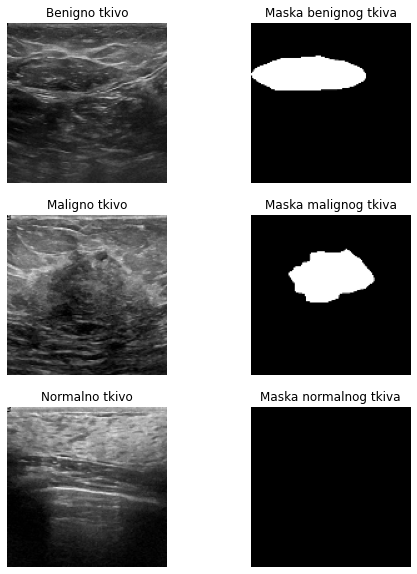

In [4]:
plt.figure(figsize=(8,10))
plt.subplot(3,2,1), plt.imshow(train_data['img'][54]), plt.title('Benigno tkivo'), plt.axis('off')
plt.subplot(3,2,2), plt.imshow(train_data['mask'][54], 'gray'), plt.title('Maska benignog tkiva'), plt.axis('off')
plt.subplot(3,2,3), plt.imshow(train_data['img'][509]), plt.title('Maligno tkivo'), plt.axis('off')
plt.subplot(3,2,4), plt.imshow(train_data['mask'][509], 'gray'), plt.title('Maska malignog tkiva'), plt.axis('off')
plt.subplot(3,2,5), plt.imshow(train_data['img'][647]), plt.title('Normalno tkivo'), plt.axis('off')
plt.subplot(3,2,6), plt.imshow(train_data['mask'][647], 'gray'), plt.title('Maska normalnog tkiva'), plt.axis('off')
plt.show()

In [5]:
def Conv2DBlock(inputTensor, numFilters, kernelSize = 3, do_batch_norm = True):
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if do_batch_norm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if do_batch_norm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
                            
    return x

In [6]:
def EncoderMiniBlock(inputTensor, numFilters, kernelSize = 3, do_batch_norm = True):
    x = Conv2DBlock(inputTensor, numFilters, kernelSize, do_batch_norm)
    p = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    return x, p

In [7]:
def DecoderMiniBlock(inputTensor, skipTensor, numFilters, kernelSize = 3, do_batch_norm = True, dropout = 0.0):
    x = tf.keras.layers.Conv2DTranspose(numFilters, (3, 3), strides = 2, padding = 'same')(inputTensor)
    x = tf.keras.layers.concatenate([x, skipTensor])
    x = tf.keras.layers.Dropout(dropout)(x)
    x = Conv2DBlock(x, numFilters, kernelSize, do_batch_norm)
    
    return x

In [8]:
def UNetModel(inputImage, numFilters = 16, droupouts = 0.1, do_batch_norm = True):

    c1, p1 = EncoderMiniBlock(inputImage, numFilters, kernelSize = 3, do_batch_norm = do_batch_norm)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2, p2 = EncoderMiniBlock(p1, numFilters * 2, kernelSize = 3, do_batch_norm = do_batch_norm)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3, p3 = EncoderMiniBlock(p2, numFilters * 4, kernelSize = 3, do_batch_norm = do_batch_norm)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4, p4 = EncoderMiniBlock(p3, numFilters * 8, kernelSize = 3, do_batch_norm = do_batch_norm)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2DBlock(p4, numFilters * 16, kernelSize = 3, do_batch_norm = do_batch_norm)

    c6 = DecoderMiniBlock(c5, c4, numFilters * 8, kernelSize = 3, do_batch_norm = do_batch_norm, dropout = droupouts)
    c7 = DecoderMiniBlock(c6, c3, numFilters * 4, kernelSize = 3, do_batch_norm = do_batch_norm, dropout = droupouts)
    c8 = DecoderMiniBlock(c7, c2, numFilters * 2, kernelSize = 3, do_batch_norm = do_batch_norm, dropout = droupouts)
    c9 = DecoderMiniBlock(c8, c1, numFilters * 1, kernelSize = 3, do_batch_norm = do_batch_norm, dropout = droupouts)
    
    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

In [10]:
modelUNet = UNetModel(tf.keras.layers.Input((128, 128, 3)))
modelUNet.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )
callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, monitor="val_loss")]

print(np.array(train_data['img']).shape, np.array(train_data['mask']).shape, np.array(train_data['img']).shape)

X_train, X_val, Y_train, Y_val = train_test_split(np.array(train_data['img']), np.array(train_data['mask']), test_size=0.1, random_state=42)
results = modelUNet.fit(X_train, Y_train, validation_split=0.1, epochs=50)


(780, 128, 128, 3) (780, 128, 128) (780, 128, 128, 3)
Epoch 1/50
20/20 [==============================] - 88s 4s/step - loss: 0.5784 - accuracy: 0.7564 - val_loss: 13.7320 - val_accuracy: 0.0918
Epoch 2/50
20/20 [==============================] - 87s 4s/step - loss: 0.3422 - accuracy: 0.9388 - val_loss: 13.3219 - val_accuracy: 0.0969
Epoch 3/50
20/20 [==============================] - 87s 4s/step - loss: 0.2967 - accuracy: 0.9430 - val_loss: 12.6589 - val_accuracy: 0.1036
Epoch 4/50
20/20 [==============================] - 88s 4s/step - loss: 0.2601 - accuracy: 0.9501 - val_loss: 8.2642 - val_accuracy: 0.2300
Epoch 5/50
20/20 [==============================] - 84s 4s/step - loss: 0.2378 - accuracy: 0.9511 - val_loss: 9.2626 - val_accuracy: 0.2374
Epoch 6/50
20/20 [==============================] - 85s 4s/step - loss: 0.2231 - accuracy: 0.9515 - val_loss: 8.9444 - val_accuracy: 0.2123
Epoch 7/50
20/20 [==============================] - 85s 4s/step - loss: 0.2009 - accuracy: 0.9544 - val

In [15]:
# save model and results
modelUNet.save('modelUNet.h5')
results.history['loss'] = np.array(results.history['loss'])
results.history['val_loss'] = np.array(results.history['val_loss'])
results.history['accuracy'] = np.array(results.history['accuracy'])
results.history['val_accuracy'] = np.array(results.history['val_accuracy'])
np.save('results.npy', results.history)

In [18]:
test_metrics = {}
test_metrics['accuracy'] = accuracy_score(Y_val.flatten(), Y_pred.flatten())
test_metrics['precision'] = precision_score(Y_val.flatten(), Y_pred.flatten())
test_metrics['recall'] = recall_score(Y_val.flatten(), Y_pred.flatten())
test_metrics['f1'] = f1_score(Y_val.flatten(), Y_pred.flatten())
test_metrics

{'accuracy': 0.9645972618689904,
 'precision': 0.7676488986193647,
 'recall': 0.7376482584661622,
 'f1': 0.7523496214878838}

In [19]:
# save test metrics
np.save('test_metrics.npy', test_metrics)

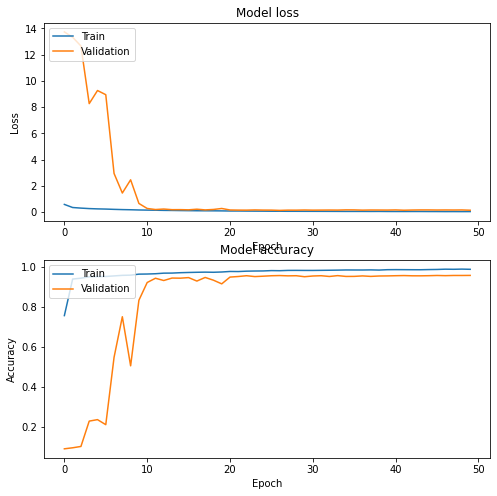

In [20]:
# prikaz kriva obucavanja - loss i accuracy (validacije i obucavanja)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplot(2, 1, 2)
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [21]:
# save predictions and true mask and values
database_new = {'img' : [],
              'mask' : [],
              'pred' : []
             }
             
for i in range(len(X_val)):
    database_new['img'].append(X_val[i])
    database_new['mask'].append(Y_val[i])
    database_new['pred'].append(Y_pred[i])

In [23]:
# save database
np.save('test_results.npy', database_new)

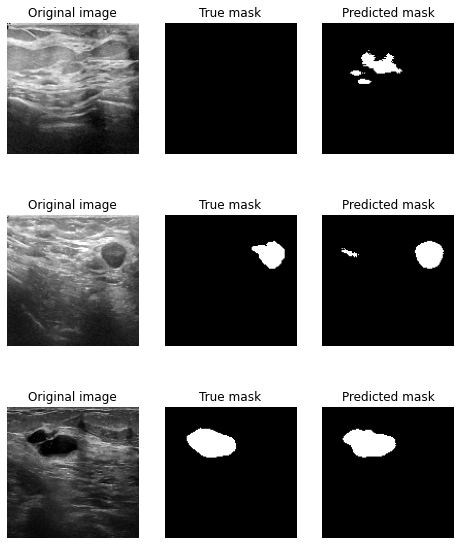

In [29]:
# prkaz nekih rezultata segmentacije iz database_new ali preko originalne slike 
i1, i2, i3 = random.sample(range(0, len(database_new['img'])), 3)
plt.figure(figsize=(8, 10))
plt.subplot(3, 3, 1), plt.imshow(database_new['img'][i1]), plt.title('Original image'), plt.axis('off')
plt.subplot(3, 3, 2), plt.imshow(database_new['mask'][i1], 'gray'), plt.title('True mask'), plt.axis('off')
plt.subplot(3, 3, 3), plt.imshow(database_new['pred'][i1], 'gray'), plt.title('Predicted mask'), plt.axis('off')
plt.subplot(3, 3, 4), plt.imshow(database_new['img'][i2]), plt.title('Original image'), plt.axis('off')
plt.subplot(3, 3, 5), plt.imshow(database_new['mask'][i2], 'gray'), plt.title('True mask'), plt.axis('off')
plt.subplot(3, 3, 6), plt.imshow(database_new['pred'][i2], 'gray'), plt.title('Predicted mask'), plt.axis('off')
plt.subplot(3, 3, 7), plt.imshow(database_new['img'][i3]), plt.title('Original image'), plt.axis('off')
plt.subplot(3, 3, 8), plt.imshow(database_new['mask'][i3], 'gray'), plt.title('True mask'), plt.axis('off')
plt.subplot(3, 3, 9), plt.imshow(database_new['pred'][i3], 'gray'), plt.title('Predicted mask'), plt.axis('off')
plt.show()

In [28]:
# save train, val and test data
tr_data = {'img' : X_train,
           'mask' : Y_train
          }
ts_data = {'img' : X_val,
           'mask' : Y_val
          }
np.save('train_data.npy', tr_data)
np.save('test_data.npy', ts_data)